In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]


# set expansion degree
L=256

# load the initial ice and sea level data
sl0,ice0 = SL.get_sl_ice_data(L)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

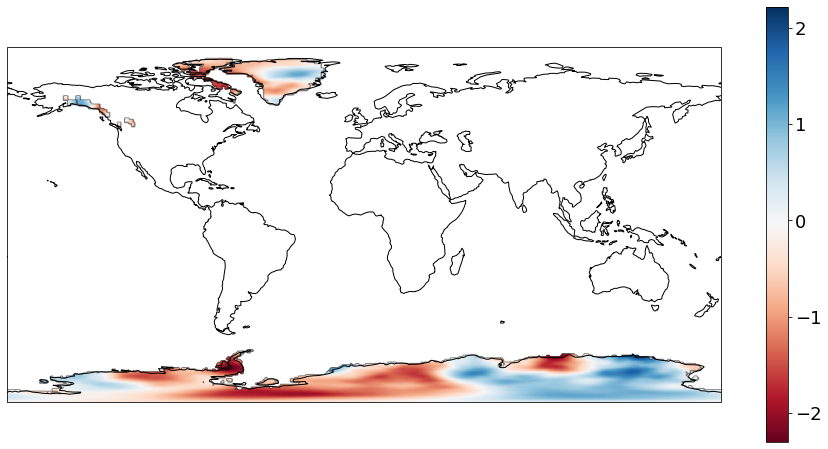

iteration =  1 relative change =  0.03276336550980612
iteration =  2 relative change =  0.0037948496188261846
iteration =  3 relative change =  0.000689524226777724
iteration =  4 relative change =  0.00014937260447819067
iteration =  5 relative change =  3.48933972488127e-05
iteration =  6 relative change =  8.597723222347106e-06
iteration =  7 relative change =  2.2231036080485955e-06
iteration =  8 relative change =  6.017004877403708e-07
iteration =  9 relative change =  1.6980631412986273e-07
iteration =  10 relative change =  4.966947494301295e-08
iteration =  11 relative change =  1.4955118642332773e-08
iteration =  12 relative change =  4.6036352803585324e-09


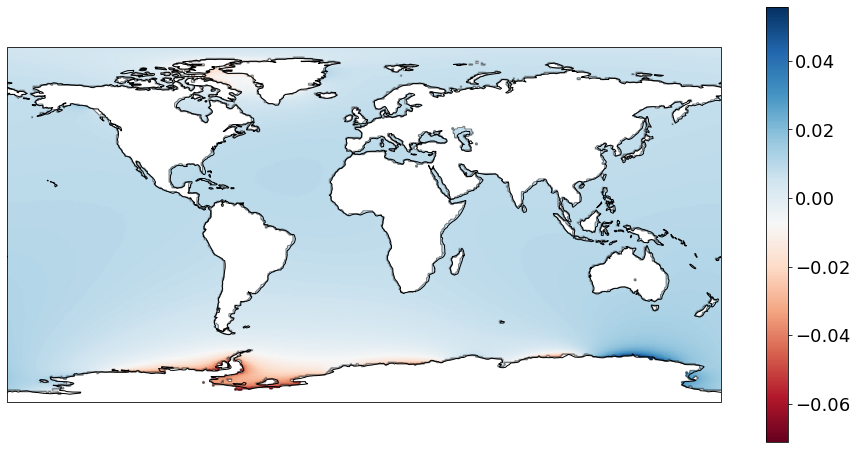

iteration =  1 relative change =  0.009460603137738662
iteration =  2 relative change =  0.0017869503150519008
iteration =  3 relative change =  0.00039579220017621193
iteration =  4 relative change =  8.844667169419479e-05
iteration =  5 relative change =  1.996776411886108e-05
iteration =  6 relative change =  4.561293077729669e-06
iteration =  7 relative change =  1.0561199896892493e-06
iteration =  8 relative change =  2.4840400587205493e-07
iteration =  9 relative change =  5.954503356920281e-08
iteration =  10 relative change =  1.4596849386767114e-08
iteration =  11 relative change =  3.6732384628844803e-09


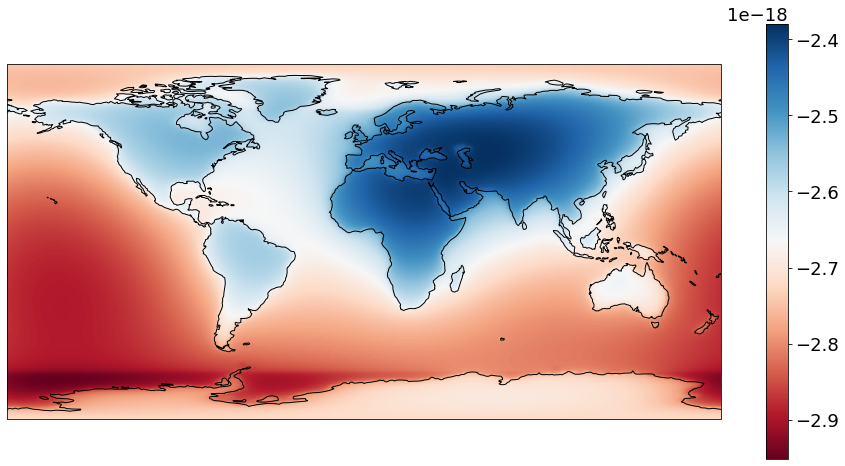

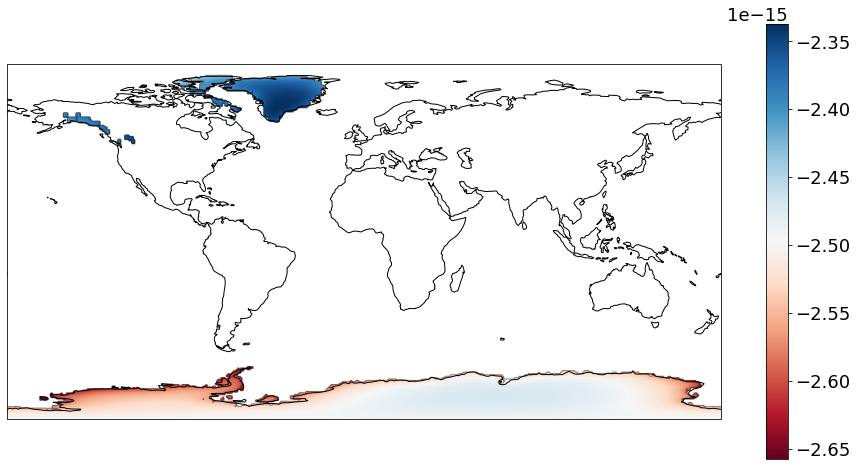

0.007922446525288762 0.007922446514869213 1.3151933397063038e-09


In [29]:
# set covariance for a random field
Q = SL.laplace_covariance(L,std = 1.0,s = 3,mu = 0.05) 

# build a random melt geometry
ice = SL.random_field(Q)*SL.ice_mask(sl0,ice0,val = 0.0)
                          
# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*ice)

# solve the fingerprint problem
zeta  = SL.rhoi*(1-C)*ice
zeta_u = pysh.SHGrid.from_zeros(lmax=L,grid='GLQ')
zeta_phi = pysh.SHGrid.from_zeros(lmax=L,grid='GLQ')
lv = np.zeros(2)
sl,u,phi,om,psi = SL.generalised_fingerprint(C,zeta,zeta_u,zeta_phi,lv)
ocean_mask = SL.ocean_mask(sl0,ice0)
SL.plot(ocean_mask*sl)

# adjoint loads for a sea level measurement
#lat =  52.48
#lon =  1.75
#zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_level_load(L,lat,lon,grid = 'GLQ',angle = 1.)

# adjoint loads for a displacement measurement
#lat =  52.48
#lon =  1.75
#zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.displacement_load(L,lat,lon,grid = 'GLQ',angle = 1.)


# adjoint loads for a potential point measurement
#lat =  52.48
#lon =  1.75
#zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.potential_load(L,lat,lon,grid = 'GLQ',angle = 1.)


#adjoint loads for a gravity measurement
#l = 2
#m = 1
#zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# adjoint loads for a sea surface height measurement
#lat =  52.48
#lon =  1.75
#zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_surface_height_load(L,lat,lon,grid = 'GLQ',angle = 1.)

zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetry_load(sl0,ice0,remove_psi = True)


# act the adjoint load on the sea level to get the observation
J =   SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

SL.plot(sl_d)
SL.plot(SL.rhoi*(1-C)*ice_mask*sl_d)

# act the load on the adjoint sea level
J2 =   SL.surface_integral(zeta*sl_d)     

#phi_lm = phi.expand(normalization='ortho')
#if(m >= 0):
#    print(phi_lm.coeffs[0,l,m])
#else:
#    print(phi_lm.coeffs[1,l,-m])

   
    
print(J,J2,np.abs((J-J2)/J))


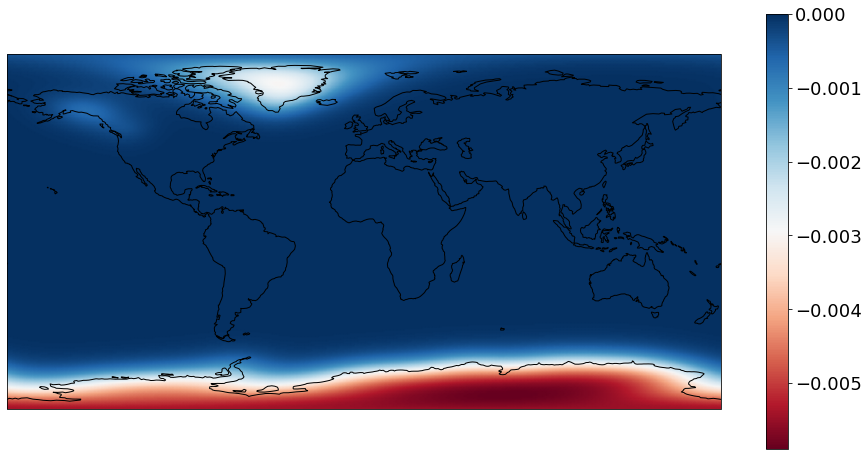

In [30]:
A = SL.surface_integral(C)
ll = (-SL.rhoi/(SL.rhow*A))*(1-C)*SL.ice_mask(sl0,ice0,val = 0)


ll_lm = ll.expand(normalization = 'ortho')
for l in range(L+1):
    ll_lm.coeffs[:,l,:] *= Q[l]
Qll = ll_lm.expand(grid='GLQ')

SL.plot(Qll)

var = SL.surface_integral(Qll*ll)

ns = 1000
GMSL_samp = np.zeros(ns)
for i in range(ns):
    Dice = SL.random_field(Q)*SL.ice_mask(sl0,ice0,val = 0.0)
    GMSL_samp[i] = SL.surface_integral(ll*Dice)
    
 


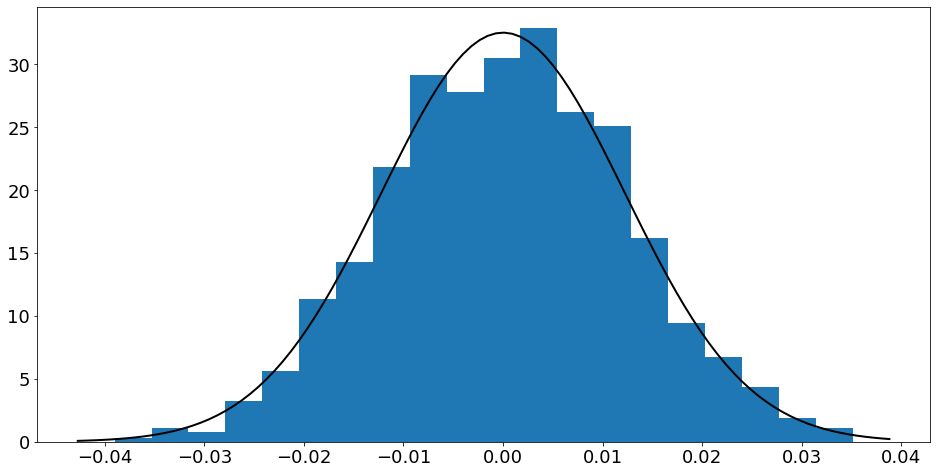

In [31]:
from scipy.stats import norm

plt.hist(GMSL_samp,bins = 20,density = True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0., np.sqrt(var))
plt.plot(x, p, 'k', linewidth=2)


plt.show()



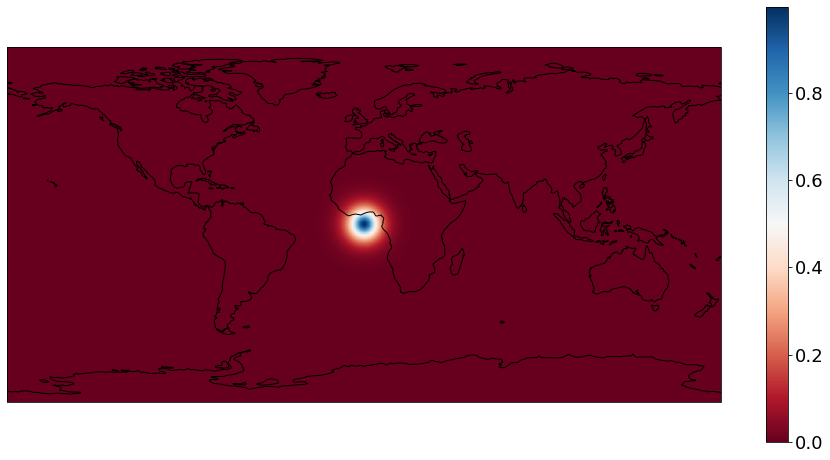

In [27]:
cf = SL.correlation_function(Q,lat0 = 0.,lon0 = 0.)
SL.plot(cf)